## Part IV : Improved initialization and Batch Normalization

In [22]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# excetions show up normally
%xmode plain

# plots show up inline
%matplotlib inline

def get_device(no_gpu=False):
    """
    Returns one of cuda / mps / cpu based on availablity
    """
    if no_gpu is True:
        return torch.device("cpu")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


# Choose the default device
no_gpu = False
default_device = get_device(no_gpu)


# Needed to import modules from src
import sys
sys.path.append('..')


# Get Project Root (needed for reading config)
import os
projectRoot = os.path.dirname(os.getcwd())
print(projectRoot)

Exception reporting mode: Plain
e:\Karpathy-Makemore


#### Load Data and associated functions

In [23]:
from src.loadData import loadData
import src.utils as utils

all_data = loadData(projectRoot)
vocab = utils.get_vocab(all_data)
print(f"Vocab Length:{len(vocab)}")

encode, decode = utils.get_encode_decode(vocab)
print(f"Encode test: {encode("emma")}\tDecode test: {decode(encode("emma"))}")
# print(f"Encode test: {encode("e")}\tDecode test: {decode(encode("e"))}")

train_percentage = 0.8
train_boundary = math.ceil(len(all_data) * train_percentage)

cv_percentage = train_percentage + 0.1
cv_boundary = math.ceil(len(all_data) * cv_percentage)

train_data = all_data[:train_boundary]
cv_data = all_data[train_boundary:cv_boundary]
test_data = all_data[cv_boundary:]

print(f"Name Counts ==> All:{len(all_data)}\tTrain:{len(train_data)}\t Validation:{len(cv_data)}\tTest: {len(test_data)} ")

Vocab Length:27
Encode test: [5, 13, 13, 1]	Decode test: emma
Name Counts ==> All:32033	Train:25627	 Validation:3203	Test: 3203 


#### Create samples from Data

In [24]:
context_length = 3

xtr, ytr = utils.get_samples(train_data, encode, context_size=context_length)
Xtr, Ytr = torch.tensor(xtr, device=default_device), torch.tensor(ytr, device=default_device)

xcv, ycv = utils.get_samples(cv_data, encode, context_size=context_length)
Xcv, Ycv = torch.tensor(xcv, device=default_device), torch.tensor(ycv, device=default_device)

xtest, ytest = utils.get_samples(test_data, encode, context_size=context_length)
Xtest, Ytest = torch.tensor(xtest, device=default_device), torch.tensor(ytest, device=default_device)

print(f"Sample Sizes ==> Training:{Xtr.shape[0]}\tValidation:{Xcv.shape[0]}\tTest:{Xtest.shape[0]}")

Sample Sizes ==> Training:157157	Validation:19429	Test:19527


#### Normal Initialization of the NN Params as was done in Part III

In [69]:
g = torch.Generator(device=default_device).manual_seed(2147483627)

# Projecting each character to 2 dimensional space 
feature_dim = 100

# Number of units in the hidden layer
n_hidden = 200

input_dim = context_length * feature_dim 
output_dim = len(vocab)

# Project to this feature space
C = torch.randn(len(vocab), feature_dim,                    device=default_device, generator=g)

# Hidden layer
W1 = torch.randn(input_dim, n_hidden,                       device=default_device, generator=g)
b1 = torch.randn(n_hidden,                                  device=default_device, generator=g)

# Output layer
W2 = torch.randn(n_hidden, output_dim,                      device=default_device, generator=g)
b2 = torch.randn(output_dim,                                device=default_device, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

learning_rate = 0.1
minibatch_size = 500
lossi_tr = []
lossi_cv = []

#### Training loop single iteration

After Random Initialization we always get a very high initial loss.

In [70]:
def forwardPass():
    # Minibatch
    ix = torch.randint(Xtr.shape[0], (minibatch_size,), device=default_device)
    X, Y = Xtr[ix], Ytr[ix]

    # Encode / Project
    Xenc = C[X]

    # Flatten
    Xenc_flattened = Xenc.view(-1, input_dim)

    # Linear_1 + Activation
    hpreact = Xenc_flattened @ W1 + b1
    h = torch.tanh(hpreact)

    # Linear_2
    logits = h @ W2 + b2

    return hpreact, h, logits, Y, F.cross_entropy(logits, Y)

hpreact, h, logits, Y, loss = forwardPass()
print(loss.item())

30.621932983398438


## Improving Network Intialization


#### Scaling down the weights of the outer layer

Below it is shown that if the value of the logits are scaled up then the cross entropy loss increases significantly. The reason for this exponentiation of the logits in the softmax phase. **Exponentiation always tends to exaggerate the differences.** 

In [71]:
def cross_entropy(logits, Y):
    logits_exp = torch.exp(logits)
    probs = logits_exp / logits_exp.sum(1, keepdim=True)

    loss = (-1) * torch.log(probs[torch.arange(logits.shape[0]), Y])
    return loss.mean()

loss = cross_entropy(logits, Y)
print(f"Loss (should match the loss from F.cross_entropy): {loss.item()}")

print("-----------------------------------------------------------------------------")
print("Test showing if logits are just scaled up, cross entropy loss increases\n")

# Test
logits_test =  torch.randn(1, 4, device=default_device)
Y_test = torch.tensor([[1]], device=default_device)

# Logits used as is
loss_test = cross_entropy(logits_test, Y_test)
print(f"Loss when logits are random numbers:\t {loss_test.item()}")

# Logits are multiplied by 5
loss_test = cross_entropy(logits_test * 5, Y_test)
print(f"Loss when logits multiplied by 5:\t {loss_test.item()}")

# Logits are multiplied by 50
loss_test = cross_entropy(logits_test * 50, Y_test)
print(f"Loss when logits multiplied by 50:\t {loss_test.item()}")

Loss (should match the loss from F.cross_entropy): 30.621931076049805
-----------------------------------------------------------------------------
Test showing if logits are just scaled up, cross entropy loss increases

Loss when logits are random numbers:	 1.9154047966003418
Loss when logits multiplied by 5:	 5.62797212600708
Loss when logits multiplied by 50:	 50.615116119384766


Hence if we can scale down the logits and ensure that they are closer to each other, we should get a better initial loss. To achieve this:
-   We can set the bias for the output layer to 0 since it is an additive term
-   We can scale down the weights in the outer layer

In [72]:
hpreact, h, logits, Y, loss = forwardPass()
print(f"Loss BEFORE scaling down the outer layer: \t{loss.item()}")

b2 = b2 * 0.0
W2 = W2 * 0.1

hpreact, h, logits, Y, loss = forwardPass()
print(f"Loss AFTER scaling down the outer layer: \t{loss.item()}")

Loss BEFORE scaling down the outer layer: 	29.615907669067383
Loss AFTER scaling down the outer layer: 	4.258240222930908


#### Kaiming He Paper : Scaling weights in the Input Layer

As shown below the activations after tanh in the input layer is concentrated in the two extremes -1 and 1 (left figure). The reason for this is W1 is randomly sampled from a Normal distribution. Hence the hpreact resembles a Normal distribution (right figure).

The most of the tanh activations are -1 or +1 then teh gradient of those neurones valishes (looking at the tanh plot, near 1 and -1 the plot almost becomes parallel to x axis hence zero gradient). As a result those neurones do not learn in that training iteration and probably this zero grad case prevents the loss gradient to proceed farther back (NOTE: This I need to check by hand)

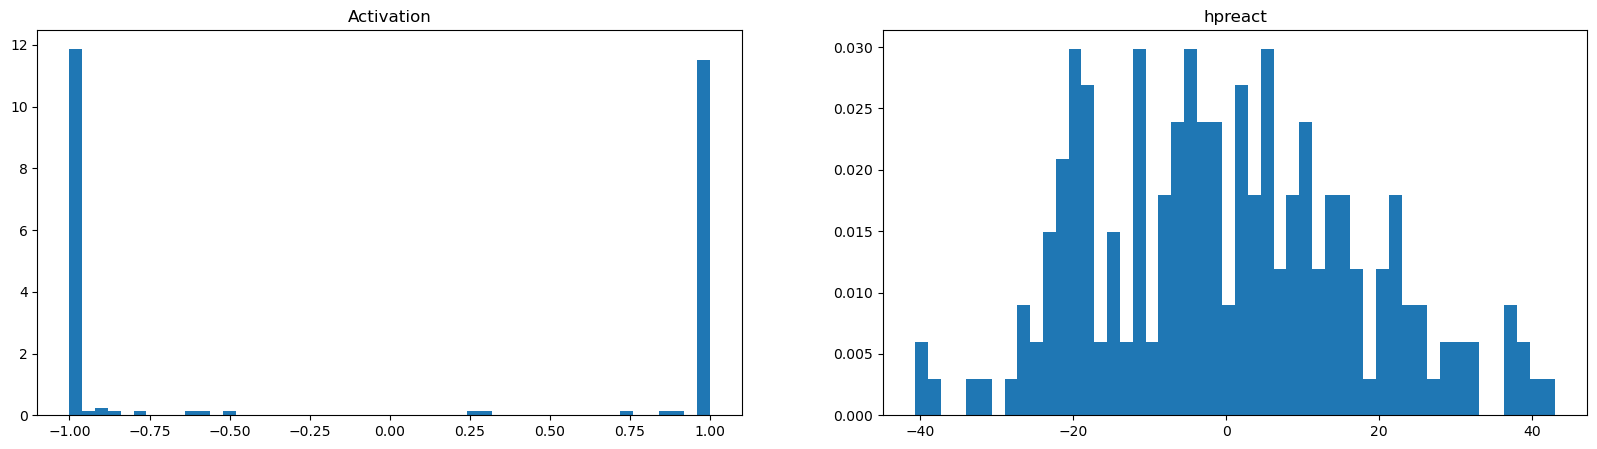

hpreact Mean:0.08202975988388062 	 std:17.334688186645508


In [73]:
def show_activation(row=1, bins=50):
    plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.hist(h[row,:].tolist(), bins=bins, density=True)
    plt.title("Activation")
    plt.subplot(122)
    plt.hist(hpreact[row,:].tolist(), bins=bins, density=True)
    plt.title("hpreact")
    plt.show()
    print(f"hpreact Mean:{hpreact[row,:].mean(0).item()} \t std:{hpreact[row,:].std(0).item()}")

show_activation(row=1)

This [Kaiming He et al. Paper](https://arxiv.org/pdf/1502.01852v1) talks about how to scale the input layer. Basically it is a good practice to always scale W1 with the sqrt of the input dimension and add a gain multiplier. Based on [this link](https://pytorch.org/docs/stable/nn.init.html) the gain multiplier for tanh is 5/3. The reason for this gain is to compensate for the squashing of the values at the talk end of the activation function.

Additionally we should also scale down b1 since a high value of hpreact will push the tanh to fire.

Loss Before Kaiming Init:3.87701153755188
Loss After Kaiming Init:3.3042373657226562


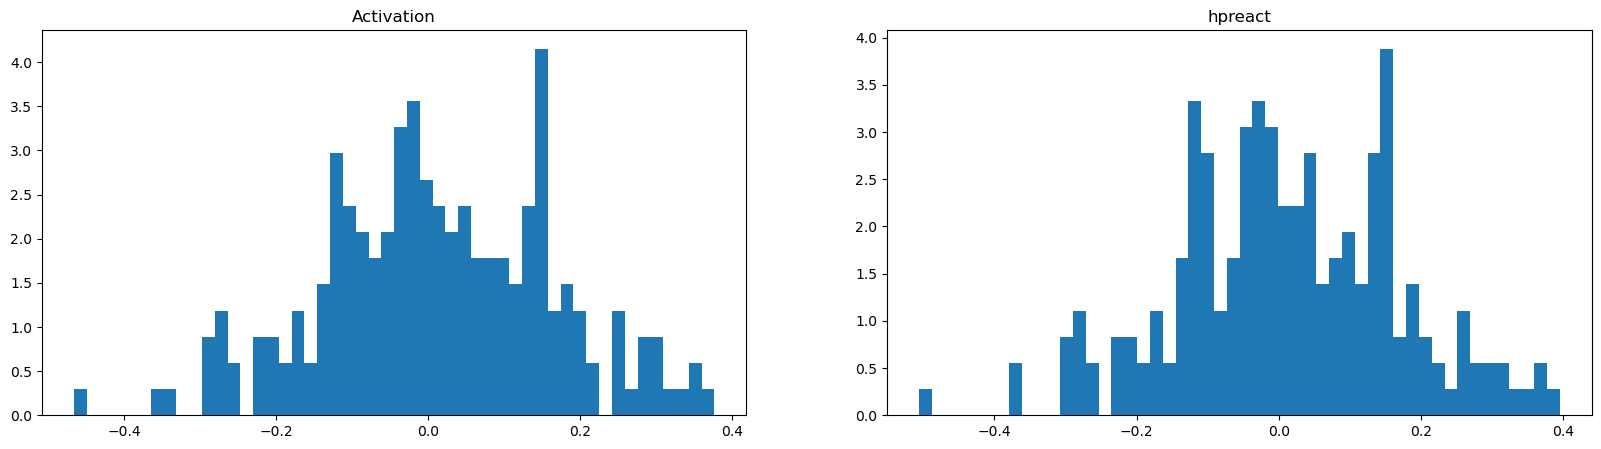

hpreact Mean:0.011470787227153778 	 std:0.1577015370130539


In [75]:
hpreact, h, logits, Y, loss = forwardPass()
print(f"Loss Before Kaiming Init:{loss.item()}")

W1 = W1 * (5/3) / math.sqrt(input_dim)
b1 = b1 * 0.01

hpreact, h, logits, Y, loss = forwardPass()
print(f"Loss After Kaiming Init:{loss.item()}")
show_activation(row=1)


After the above 2 modifications, it can be seen that the std in the tanh layer is roughly resembles a standard normal (0 mean and 1 std). It is mentioned in the lecture that after the introduction of normalization layer (batch norm, layer norm etc.) and advanced optimization technique like Adam the initialization has become less sensitive to final loss. 